In [1]:
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from skimage import exposure
import random
import sys

In [2]:
im1 = np.array(Image.open('band1.gif', 'r'))
im2 = np.array(Image.open('band2.gif', 'r'))
im3 = np.array(Image.open('band3.gif', 'r'))
im4 = np.array(Image.open('band4.gif', 'r'))

In [3]:
# 1. Initialize corresponding k color values for k=3 clusters

k=2
color = [[255,69,0],[255,255,255],[0,255,255],[255,0,0],[0,255,0],[0,0,255]]

In [4]:
# 2. Input satellite images, imageInput (512, 512,4)

imageinput=np.array([im1,im2,im3,im4]).T
#imageinput=imageinput.reshape(512,512,4)
print(imageinput.shape)

(512, 512, 4)


In [5]:
# 3. Initialize clusteredImage as the output image

clusteredImage = np.zeros((512,512,3),dtype='uint8') 

In [6]:
# 4. Select k=3 random x,y co-ordinates and extract pixel values from imageInput 

coord = np.array(([300,100],[200,300],[200,400],[100,72],[121,96]))

b1=[]
b2=[]
b3=[]
b4=[]
for i in range(k):
    b1.append(im1[coord[i][0],coord[i][1]])
    b2.append(im2[coord[i][0],coord[i][1]])
    b3.append(im3[coord[i][0],coord[i][1]])
    b4.append(im4[coord[i][0],coord[i][1]])

    
initCentroids=np.array([b1,b2,b3,b4]).T
print(initCentroids.shape)
print()
print(initCentroids[1])

(2, 4)

[11 13 16 19]


In [7]:
# 5. Clustering

#initCentroids (3, 4)
#(512, 512, 4)

def euclidean_dist(x1,x2):
    dist = sum([(a - b) ** 2 for a, b in zip(x1, x2)])**0.5
    return dist


def clustering(k,imageinput,initCentroids):
    min_dist = sys.maxsize

    classData = np.zeros((512,512))

    for i in range(512):
        for j in range(512):
            for x in range(k):
                distance = euclidean_dist(imageinput[i,j,:],initCentroids[x])

                if(min_dist > distance):
                    min_dist = distance
                    label = x

            classData[i][j] = label
            min_dist = sys.maxsize
            
    return classData


def updateCentroids(imageinput,classData):
    s=np.zeros((1,4))
    total = 0
    updatedCentroids = np.zeros((k,4))

    for x in range (k):
        for i in range(512):
            for j in range(512):
                if classData[i][j]==x:
                    s+= imageinput[i,j,:]
                    total+=1
        s = s/total
        updatedCentroids[x] = s
        s=np.zeros((1,4))
        total = 0
    return updatedCentroids

# loop until stopping criteria 

# setting threshold
threshold = 15

for i in range(threshold):
    classData = clustering(k,imageinput,initCentroids)
    updatedCentroids = np.round(updateCentroids(imageinput,classData))
    if (initCentroids==updatedCentroids).all():
        print("matched")
        print(i)
        break
    else:
        initCentroids = updatedCentroids

<ipython-input-7-08d3e30e782d>:7: RuntimeWarning: overflow encountered in ubyte_scalars
  dist = sum([(a - b) ** 2 for a, b in zip(x1, x2)])**0.5


matched
11


In [8]:
print(updatedCentroids)

[[ 8.  9. 12. 16.]
 [10. 11. 14. 25.]]


In [9]:
# 6. assign color

for i in range(512):
    for j in range(512):
        clusteredImage[j,i,:] = color[int(classData[i,j])]
        
clusteredImage.shape

(512, 512, 3)

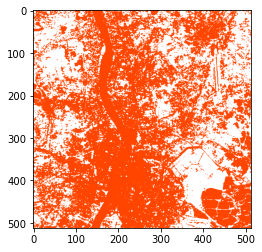

In [10]:
# 7. Display clusteredImage

img = Image.fromarray(clusteredImage, 'RGB')
imgplot = plt.imshow(img)
plt.show()


### Evaluation of clustering - silhouette coefficient

In [11]:
def calSilhouette(p,classData,imageInput,k):
    
    total = 0
    distance = 0
    
    pixelValue = classData[p[0],p[1]]
    
    for i in range(512):
        for j in range(512):
            if classData[i][j] == pixelValue:
                distance += euclidean_dist(imageInput[i,j,:],imageInput[p[0],p[1],:])
                total+=1               
    a = distance/total
    
    # distances of other cluster
    
    d = []
    for x in range(k):
        if x == pixelValue:
            continue
        else:
            total = 0
            distance = 0
            for i in range(512):
                for j in range(512):
                    if classData[i][j] == x:
                        distance += euclidean_dist(imageInput[i,j,:],imageInput[p[0],p[1],:])
                        total+=1 
            
            if(total != 0):
                d.append(distance/total) 
            else:
                d.append(sys.maxsize)

    b = min(d)
    s = (b-a)/max(b,a)
    return s

In [12]:
# 1. Initialize silhouette array s (512,512)

s = np.zeros((512,512))

In [13]:
# 2. For each pixel p in classData, sp = calSilhouette(p)

for i in range(5):
    for j in range(5):
        s[i][j] = calSilhouette([i,j],classData,imageinput,k)

<ipython-input-7-08d3e30e782d>:7: RuntimeWarning: overflow encountered in ubyte_scalars
  dist = sum([(a - b) ** 2 for a, b in zip(x1, x2)])**0.5


In [14]:
# 3. silhouette_coeff = max(s)

silhouette_coeff_2 = np.amax(s) 
print(silhouette_coeff_2)

0.4892631542382532


In [15]:
# Repeating same process for k = 3,4,5

def kmeans(k,imageinput,coord,threshold):

    clusteredImage = np.zeros((512,512,3),dtype='uint8')
    initCentroids = []

    for i in range(k):
        initCentroids.append(imageinput[coord[i][0],coord[i][1],:])

    initCentroids = np.array(initCentroids)

    # we will be updating centroids later
    centroids = initCentroids

    # loop until stopping criteria is met
    count = 0
    while(count < threshold):
        classData = clustering(k,imageinput,centroids)
        updatedCentroids = np.round(updateCentroids(imageinput,classData))
        if (centroids==updatedCentroids).all():
            print("same centroids")
            break
        else:
            centroids = updatedCentroids
        count+=1

    # form image
    for i in range(512):
        for j in range(512):
            clusteredImage[j,i,:] = color[int(classData[i,j])]

    img = Image.fromarray(clusteredImage, 'RGB')
    imgplot = plt.imshow(img)
    plt.show()

<ipython-input-7-08d3e30e782d>:7: RuntimeWarning: overflow encountered in ubyte_scalars
  dist = sum([(a - b) ** 2 for a, b in zip(x1, x2)])**0.5


same centroids


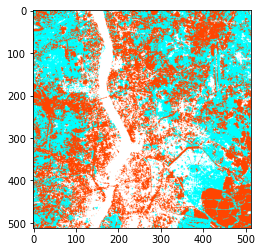

In [16]:
k = 3
kmeans(k,imageinput,coord,threshold)

In [17]:
# silloutte
s = np.zeros((512,512))
for i in range(5):
    for j in range(5):
        s[i][j] = calSilhouette([i,j],classData,imageinput,k)
silhouette_coeff_3 = np.amax(s)

<ipython-input-7-08d3e30e782d>:7: RuntimeWarning: overflow encountered in ubyte_scalars
  dist = sum([(a - b) ** 2 for a, b in zip(x1, x2)])**0.5


<ipython-input-7-08d3e30e782d>:7: RuntimeWarning: overflow encountered in ubyte_scalars
  dist = sum([(a - b) ** 2 for a, b in zip(x1, x2)])**0.5


same centroids


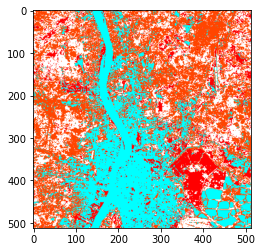

In [18]:
k = 4
kmeans(k,imageinput,coord,threshold)

In [19]:
# silloutte
s = np.zeros((512,512))
for i in range(5):
    for j in range(5):
        s[i][j] = calSilhouette([i,j],classData,imageinput,k)
silhouette_coeff_4 = np.amax(s)

<ipython-input-7-08d3e30e782d>:7: RuntimeWarning: overflow encountered in ubyte_scalars
  dist = sum([(a - b) ** 2 for a, b in zip(x1, x2)])**0.5


<ipython-input-7-08d3e30e782d>:7: RuntimeWarning: overflow encountered in ubyte_scalars
  dist = sum([(a - b) ** 2 for a, b in zip(x1, x2)])**0.5


same centroids


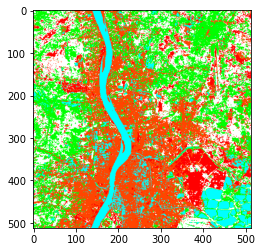

In [20]:
k = 5
kmeans(k,imageinput,coord,threshold)

In [21]:
# silhouette
s = np.zeros((512,512))
for i in range(5):
    for j in range(5):
        s[i][j] = calSilhouette([i,j],classData,imageinput,k)
silhouette_coeff_5 = np.amax(s)

<ipython-input-7-08d3e30e782d>:7: RuntimeWarning: overflow encountered in ubyte_scalars
  dist = sum([(a - b) ** 2 for a, b in zip(x1, x2)])**0.5


In [23]:
print(silhouette_coeff_2)
print(silhouette_coeff_3)
print(silhouette_coeff_4)
print(silhouette_coeff_5)

0.4892631542382532
0.4892631542382532
0.4892631542382532
0.4892631542382532
